In [1]:
import pandas as pd
import numpy as np
import math
from collections import Counter
import os
from datetime import datetime
from os.path import join as pj
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss
import torch
from sklearn.decomposition import PCA
from sklearn.svm import SVC , SVR
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split , LeaveOneOut, cross_val_score
from lightgbm import LGBMClassifier , LGBMRegressor

month_map = dict(zip(['January', 'February', 'March', 'April', 'May', 'June',
     'July', 'August', 'September', 'October', 'November', 'December'],
     list(range(1,13))))
parse_date = lambda x: datetime.strptime(x , '%Y-%m-%d')
future_cols =['adr', 'is_canceled', 'reservation_status_date', 'reservation_status']
arrival_date_cols =['arrival_date_year', 'arrival_date_month', 'arrival_date_day_of_month'] 


root = 'dataset'
train_x_path = pj(root ,'train.csv')
train_y_path = pj(root , 'train_label.csv')
test_x_path = pj(root , 'test.csv')
test_y_path = pj(root,  'test_nolabel.csv')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Feature selection

Parts:
- Main table (with all guessed future columns)
- **Target**: is_cancel 
- **Target**: adr

In [2]:
### train


In [3]:
def preprocessing(df, drop_future = False, Test=False):
    
    df = df.fillna(0)
    df = df.replace({'arrival_date_month' : month_map})
    df['arrival_date'] = df[arrival_date_cols].astype(str).agg('-'.join, axis=1)
    df['arrival_date'] = df['arrival_date'].apply(parse_date)
    df = df.drop(arrival_date_cols, axis = 1)
    
    

    if not Test:
        df['reservation_status_date']=df['reservation_status_date'].apply(parse_date)

        stay_days = (df['reservation_status_date']-df['arrival_date'])\
                    .apply(lambda x : x.days)
        df['stay_days']=stay_days
        df['stay_days']=df['stay_days'].apply(lambda x: 0 if x<=0 else x)
        
    if drop_future:
        for future in future_cols:
            if future in df.columns:
                df = df.drop([future] ,axis=1)
    return df

def get_sub_target(df_x ,df_x_t, target = 'adr',remove_redun=True ):
    """cols_future :
    
        'adr',
        'is_canceled',
        'reservation_status',
        'reservation_status_date',
        'stay_days'
    """
    cols = [
        'arrival_date',
        'hotel',
        'lead_time',
        'arrival_date_week_number',
        'stays_in_weekend_nights',
        'stays_in_week_nights',
        'adults',
        'children',
        'babies',
        'meal',
        'country',
        'market_segment',
        'distribution_channel',
        'is_repeated_guest',
        'previous_cancellations',
        'previous_bookings_not_canceled',
        'reserved_room_type',
        'assigned_room_type',
        'booking_changes',
        'deposit_type',
        'agent',
        'company',
        'days_in_waiting_list',
        'customer_type',
        'required_car_parking_spaces',
        'total_of_special_requests']

    if remove_redun:
        if target=='adr':
            print('Detect target ',target)
            pass
        if target=='is_canceled':
            print('Detect target ',target)
            pass
        if target=='stay_days':
            print('Detect target ',target)
            cols.remove('arrival_date_week_number')
            cols.remove('company')
            cols.remove('children')
            
            df_x = deepcopy(df_x)
            df_x['adr']=df_x['adr'].apply(lambda x: max(0, x))
            

    
    df_all = pd.concat([            \
                        df_x[cols], \
                        df_x_t[cols]\
                       ] ,          \
                       axis=0).reset_index(drop=True)
    
    target_y = df_x[target].values

    n_train = target_y.shape[0]
    print('n of train: ',n_train)
    df_feat = pd.get_dummies(df_all)
    print('Total shape: ',df_feat.shape)
    df_feat_train =df_feat.iloc[:n_train,:]
    print('Train shape: ',df_feat_train.shape)
    df_feat_test = df_feat.iloc[n_train: , :]
    print('Test shape: ',df_feat_test.shape)
    
    return df_feat_train, df_feat_test , target_y

def DR(np_x_train , np_x_test , n=40):
    pca = PCA(n_components=n)
    transformed = pca.fit_transform(deepcopy(np_x_train))
    transformed_t = pca.transform(deepcopy(np_x_test))
    return transformed , transformed_t



def train_sub_target(df_x,y,target='is_canceled',df_x_test = None ,model='lgb',stratify=False,params={}):
    
    x=df_x.drop(['arrival_date'],axis=1)

    
    if target==  'is_canceled':
        if model=='svm':
            model_sub = SVC()
        else:
            model_sub = LGBMClassifier(objective='binary',
                              metric='cross-entropy',
                              **params)
        
    elif target==  'stay_days':
        if model=='svm':
            model_sub = SVR()
        else:
            model_sub = LGBMRegressor(objective='regression',
                               metrics='mse')
        
    elif target==  'adr':
        if model=='svm':
            model_sub = SVR()
        else:
            model_sub = LGBMRegressor(objective='regression',
                               metrics='mse')
        
    
    measure = lambda true,pred : mae(true , pred) \
                                 if target in ['adr' , 'stay_days']\
                                 else zero_one_loss(true, pred)

    
    
    if df_x_test is not None:
        x_test =df_x_test.drop(['arrival_date'], axis=1)
        x_train, y_train = x,y
    else:
        
        if stratify:
            x_train, x_val , y_train, y_val = train_test_split(x,y,
                                                               test_size=.5,
                                                              stratify=y)
        else:
            x_train, x_val , y_train, y_val = train_test_split(x,y,
                                                               test_size=.5)
        
    model_sub.fit(x_train ,y_train)
    y_trained = model_sub.predict(x_train)
    print('fitness: ',measure(y_train , y_trained))
    
    if df_x_test is not None:
        y_pred = model_sub.predict(x_test)
        print('Test set predict shape: ',y_pred.shape)
        
        return model_sub , y_pred
        
    else:
        y_pred = model_sub.predict(x_val)
        print('validation: ',
              measure(y_val , y_pred) )
        return model_sub , model_sub.predict(x)

def data_augmentor(x, y, sigma=0.1, times=10, balance = True, df=False):
    x_g = deepcopy(x)
    y_g = deepcopy(y)
    
    
    if df:
        x_date = x_g[['arrival_date']].values
        x_g = x_g.drop('arrival_date' , axis =1).values
        y_g = y_g[['label']].values
    else:
        y_g = np.array(y_g).reshape(-1 ,1)
    print('original shape: ', x_g.shape)
    if balance:
        y_flat = y_g.flatten()
        most_count_per_class= max([v for k,v in Counter(y_flat).items()])
        hope_num_per_class = most_count_per_class + 2

        class_id_map ={}
        for i,v in enumerate(y_flat):
            if class_id_map.get(v , None) == None:
                class_id_map[v]=[]
            class_id_map[v].append(i)
        for k,v in class_id_map.items():
            class_id_map[k] = np.array(v)
            
        all_selected_index = []

        for cla,id_list in class_id_map.items():
            num_to_gene = hope_num_per_class - len(id_list)
            selected_index_of_list = np.random.randint(0, len(id_list) ,num_to_gene)
            selected_index_of_row = id_list[selected_index_of_list]

            all_selected_index = all_selected_index + selected_index_of_row.tolist()
        x_for_balance = deepcopy(x_g[all_selected_index ,:])
        y_for_balance = deepcopy(y_g[all_selected_index ,:])
        
        if df:
            date_for_balance = deepcopy(x_date[all_selected_index , :])
            x_date = np.concatenate([x_date , date_for_balance] , axis =0)
            
            
        
        x_noise = np.random.normal(0 , sigma , (len(all_selected_index) ,x_g.shape[1]))
        x_g = np.concatenate([x_g , x_for_balance+x_noise], axis =0)
        y_g = np.concatenate([y_g , y_for_balance], axis =0)
        print('balanced shape: ', x_g.shape)
    
    
    if df:
        x_date_ = deepcopy(x_date)
    x_ = deepcopy(x_g)
    y_ = deepcopy(y_g)
    for _ in range(times):
        
        if df:
            x_date = np.concatenate([x_date , x_date_] , axis =0)

        
        x_noise = np.random.normal(0,sigma, x_.shape)
        x_g = np.concatenate([x_g , x_ +x_noise], axis =0)
        y_g = np.concatenate([y_g , y_], axis =0)
    print('augmented shape:' , x_g.shape)
    
    
    if df:
        x_date = pd.DataFrame(x_date , columns = ['arrival_date'])
        x_g = pd.DataFrame(x_g , columns = x.drop('arrival_date',axis=1 ).columns)
        x_g = pd.concat([x_date , x_g] , axis = 1)
        y_g = pd.DataFrame( y_g , columns =  ['label'] )
        y_g = pd.concat([x_date , y_g] , axis =1)
        
    
    return x_g , y_g

    
def final(df , df_y , df_test = None, times = 10 , 
          df_y_t= None,
          output_fn ='test_output_.csv',
          model='lgb', 
          params={}):
    """
    df, df_test : DataFrame
    [
        arrival_date , 
        adr* , 
        is_cannceled*, 
        stay_days*
    ]
    還沒aggregation
    
    -> df_y , df_y_t: DataFrame
    """
    
    # Training data
    valid_x =deepcopy(df)
    
    valid_x_drop = valid_x.loc[valid_x['is_canceled']==0,:].reset_index(drop=True)
    valid_x_drop = valid_x.drop('is_canceled', axis=1)
#     df_y = df_y.loc[valid_x['is_canceled']==0,:].reset_index(drop=True)
    valid_x_drop['adr'] = valid_x_drop['adr'].apply(lambda x: max(0,x))
    valid_x_drop['stay_days'] = valid_x_drop['stay_days'].apply(lambda x: max(0,x))
    valid_x_drop['sum_adr'] = valid_x_drop['stay_days']*valid_x_drop['adr']
    sum_adr = valid_x_drop.groupby('arrival_date').sum()[['sum_adr']]

    vsum_normal = sum_adr['sum_adr']
    vsum_normal = 9*(vsum_normal - vsum_normal.min())/\
                (vsum_normal.max() - vsum_normal.min())

    
    x, y =  vsum_normal.values.reshape(-1 , 1),df_y['label']
    
    sc = StandardScaler()
    
    if df_test is not None:
        # Testing data
        valid_x_test =deepcopy(df_test)

        valid_x_drop_test = valid_x_test.loc[valid_x['is_canceled']==0,:].reset_index(drop=True)
        valid_x_drop_test['adr'] = valid_x_drop_test['adr'].apply(lambda x: max(0,x))
        valid_x_drop_test['sum_adr'] = valid_x_drop_test['stay_days']*valid_x_drop_test['adr']
        sum_adr_test = valid_x_drop_test.groupby('arrival_date').sum()[['sum_adr']]

        vsum_normal_test = sum_adr_test['sum_adr']
        vsum_normal_test = 9*(vsum_normal_test - vsum_normal_test.min())/\
                    (vsum_normal_test.max() - vsum_normal_test.min())
        x_train, y_train = x,y
        
        x_test = vsum_normal_test.values.reshape(-1 , 1 )
        
        
        ######## augmentation 
        x_train , y_train = data_augmentor(x_train ,y_train , times = times , balance = True )
        
        
        x_train = sc.fit_transform(x_train)
        x_test = sc.transform(x_test)
        
        
    else:
    
        
        ######## augmentation -- just balance
        x, y = data_augmentor(x, y , times = 0 , balance = True )
        
        x_train,x_val,y_train,y_val = train_test_split(x,y , test_size = 0.5, stratify = y)
        
        ######## augmentation -- for training data
        x_train , y_train = data_augmentor(x_train ,y_train , times = times , balance = True )
        
        x_train = sc.fit_transform(x_train)
        x_val = sc.transform(x_val)
    
    
    
    
    if model=='svm':
        model_lgb= SVC()
    else:
        model_lgb = LGBMClassifier(num_class =10 ,
                                   objective='multiclass',
                                   metric='multi_logloss',
                                  **params)
    if df_test is not None:
        y_train = y_train.reshape(-1,)
        
        if model=='lgb':
            model_lgb.fit(x_train , y_train )
        elif model=='lgbreg':
            
            model_lgb = LGBMRegressor(objective='regression',
                               metrics='mse')
            model_lgb.fit(x_train , y_train )
            y_train_svc = model_lgb.predict(x_train)
            
            svc = SVC()
            svc.fit(y_train_svc.reshape(-1,1) , y_train)
            
        else:
            model_lgb.fit(x_train , y_train)
    
    else:
        if model=='lgb':
            model_lgb.fit(x_train , y_train ,eval_set = (x_val,y_val))
        elif model=='lgbreg':
            
            y_train , y_val = y_train.reshape(-1 ,) , y_val.reshape(-1 ,)
            
            model_lgb = LGBMRegressor(objective='regression',
                               metrics='mse')
            model_lgb.fit(x_train , y_train , eval_set = (x_val , y_val))
            y_train_svc = model_lgb.predict(x_train)
            
            svc = SVC()
            svc.fit(y_train_svc.reshape(-1 ,1) , y_train)
            
        else:
            model_lgb.fit(x_train , y_train)
    
    y_trained = model_lgb.predict(x_train)
    print('fitness: ',mae(y_train , y_trained))
    
    if df_test is not None:
        y_pred = model_lgb.predict(x_test)
        
        if model=='lgbreg':
            y_pred = svc.predict(y_pred.reshape(-1 ,1))
        
        print('Test set predict shape: ',y_pred.shape)
        print('Test df_y_t shape:      ',df_y_t.shape)
        df_y_t['label']=y_pred
        print('Test set label \n',df_y_t.head())
        df_y_t.to_csv(output_fn , index = False)
        
        return model_lgb , df_y_t
        
    else:
        y_pred = model_lgb.predict(x_val)
        if model=='lgbreg':
            y_pred = svc.predict(y_pred.reshape(-1 ,1))
        print('validation mae: ',mae(y_val , y_pred))
    
    return model_lgb, x , y




## Load data

In [4]:
df_x = pd.read_csv(train_x_path)
df_y = pd.read_csv(train_y_path)

df_x_t = pd.read_csv(test_x_path)
df_y_t = pd.read_csv(test_y_path)
df_x = preprocessing(df_x)
df_y['arrival_date'] = df_y['arrival_date'].apply(parse_date)


df_x_t = preprocessing(df_x_t, Test = True)
df_y_t['arrival_date'] = df_y_t['arrival_date'].apply(parse_date)

In [5]:
df_x.columns

Index(['ID', 'hotel', 'is_canceled', 'lead_time', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'meal', 'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type', 'agent',
       'company', 'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'arrival_date',
       'stay_days'],
      dtype='object')

# Target: is_canceled

In [6]:
df_can , df_can_t, can_y = get_sub_target(df_x ,
                                          df_x_t ,
                                          target = 'is_canceled')


Detect target  is_canceled
n of train:  91531
Total shape:  (119390, 244)
Train shape:  (91531, 244)
Test shape:  (27859, 244)


In [7]:
# df_can_y = deepcopy(df_can[['arrival_date']])
# df_can_y['label'] = can_y
# df_can_aug , can_y_aug = data_augmentor(df_can , df_can_y ,  times = 10 , df=True , balance=True) 

# can_model,can_pred = train_sub_target(df_can_aug, can_y_aug.label,
#                              target='is_canceled', stratify =True)
can_model,can_pred = train_sub_target(df_can, can_y,
                             target='is_canceled', stratify =True)

fitness:  0.10444662952037587
validation:  0.11569724249442814


In [8]:
can_model,can_pred_t = train_sub_target(df_can, can_y,
                                 target='is_canceled',
                                 df_x_test = df_can_t )
# can_model,can_pred_t = train_sub_target(df_can_aug, can_y_aug.label,
#                                  target='is_canceled',
#                                  df_x_test = df_can_t ,
#                                        stratify=True)

fitness:  0.10885929357266932
Test set predict shape:  (27859,)


# Target: adr

In [9]:
df_adr, df_adr_t, adr_y = get_sub_target(df_x ,
                                         df_x_t,
                                         target = 'adr')


Detect target  adr
n of train:  91531
Total shape:  (119390, 244)
Train shape:  (91531, 244)
Test shape:  (27859, 244)


In [10]:
adr_model,adr_pred = train_sub_target(df_adr, adr_y,
                             target='adr')

fitness:  14.07167642450709
validation:  14.577928071938187


In [11]:
adr_model,adr_pred_t = train_sub_target(df_adr, adr_y,
                                         target='adr',
                                         df_x_test = df_adr_t )

fitness:  14.319592695842827
Test set predict shape:  (27859,)


In [12]:
n1,n2 = 9*(adr_y-adr_y.min())/(adr_y.max()- adr_y.min()) ,9*(adr_pred-adr_pred.min())/(adr_pred.max()-adr_pred.min())



mae(n1,n2)

3.3039037394708894

# Target: stay_days

In [13]:
df_day, df_day_t, day_y = get_sub_target(df_x ,
                                         df_x_t,
                                         target = 'stay_days',
                                         remove_redun=True)
# params={'max_depth':1,
#         'max_leaf':100}

Detect target  stay_days
n of train:  91531
Total shape:  (119390, 241)
Train shape:  (91531, 241)
Test shape:  (27859, 241)


In [14]:
day_model,day_pred = train_sub_target(df_day, day_y,
                             target='stay_days',
                             model='lgb')

fitness:  0.6873427671143668
validation:  0.720100791027553


In [15]:
day_model,day_pred_t = train_sub_target(df_day, day_y,
                                         target='stay_days',
                                         df_x_test = df_day_t )

fitness:  0.6895243168566692
Test set predict shape:  (27859,)


# Final

In [16]:

print('\ntrain array shape:\n\n',[adr_pred.shape,
    can_pred.shape,
    day_pred.shape])
print('\ntest array shape:\n\n',[adr_pred_t.shape,
    can_pred_t.shape,
    day_pred_t.shape])


train array shape:

 [(91531,), (91531,), (91531,)]

test array shape:

 [(27859,), (27859,), (27859,)]


In [17]:
df_x['arrival_date'].values.shape

(91531,)

In [18]:
day_pred = np.array(list(map(lambda x: math.ceil(x),day_pred)))

In [19]:
df_final   = pd.DataFrame(dict(zip(['arrival_date', 'adr' , 'stay_days', 'is_canceled'],
                                   [    df_x['arrival_date'].values,
                                        adr_pred,
                                        day_pred,
                                        can_pred]
                                  )
                              ))
df_final_true = deepcopy(df_x[[ 'adr' , 'stay_days', 'is_canceled']])
df_final_true.columns=['adr_T', 'stay_days_T', 'is_canceled_T']
df_final_cat   = pd.concat([df_final, df_final_true], axis=1)
df_final_cat = df_final_cat[ ['adr' ,'adr_T',   'stay_days','stay_days_T', 'is_canceled','is_canceled_T']]

df_final_t = pd.DataFrame(dict(zip(['arrival_date', 'adr' , 'stay_days', 'is_canceled'],
                                   [    df_x_t['arrival_date'].values,
                                        adr_pred_t,
                                        day_pred_t,
                                        can_pred_t]
                                  )
                              ))

In [20]:
print('==================== Real ================================== ')
print(df_final.head(10))
print('==================== Test ================================== ')
print(df_final_t.head(10))
print('=============== Predict & Real ============================= ')
print(df_final_cat.head(15))

==================== Real ================================== 
  arrival_date        adr  stay_days  is_canceled
0   2015-07-01 -26.179980          1            0
1   2015-07-01  55.925976          2            0
2   2015-07-01  82.000499          2            0
3   2015-07-01  82.000499          2            0
4   2015-07-01  82.000499          2            0
5   2015-07-01  82.000499          2            0
6   2015-07-01  82.000499          2            0
7   2015-07-01  82.000499          2            0
8   2015-07-01  82.000499          2            0
9   2015-07-01  55.925976          2            0
==================== Test ================================== 
  arrival_date         adr  stay_days  is_canceled
0   2017-04-01   89.763629   4.807530            0
1   2017-04-01   51.686171   3.813217            1
2   2017-04-01   60.913530   4.108961            0
3   2017-04-01  129.834947   2.289515            1
4   2017-04-01  194.868244   2.377707            1
5   2017-04-01   98.

## Partial training with aug


In [25]:

model_partial,x_all,y_all = final(df_final,
                                    df_y,
                                 model='lgb')

original shape:  (640, 1)
balanced shape:  (1880, 1)
augmented shape: (1880, 1)
original shape:  (940, 1)
balanced shape:  (960, 1)
augmented shape: (10560, 1)
[1]	valid_0's multi_logloss: 1.71428
[2]	valid_0's multi_logloss: 1.44111
[3]	valid_0's multi_logloss: 1.25703
[4]	valid_0's multi_logloss: 1.12098
[5]	valid_0's multi_logloss: 1.01652
[6]	valid_0's multi_logloss: 0.934207
[7]	valid_0's multi_logloss: 0.86821
[8]	valid_0's multi_logloss: 0.814873
[9]	valid_0's multi_logloss: 0.771301
[10]	valid_0's multi_logloss: 0.735503
[11]	valid_0's multi_logloss: 0.706133
[12]	valid_0's multi_logloss: 0.681912
[13]	valid_0's multi_logloss: 0.661747
[14]	valid_0's multi_logloss: 0.645229
[15]	valid_0's multi_logloss: 0.631429
[16]	valid_0's multi_logloss: 0.619901
[17]	valid_0's multi_logloss: 0.61042
[18]	valid_0's multi_logloss: 0.602554
[19]	valid_0's multi_logloss: 0.596186
[20]	valid_0's multi_logloss: 0.590735
[21]	valid_0's multi_logloss: 0.586233


/mnt/data/anaconda3/envs/charlie_dgtn/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


[22]	valid_0's multi_logloss: 0.582443
[23]	valid_0's multi_logloss: 0.579341
[24]	valid_0's multi_logloss: 0.576885
[25]	valid_0's multi_logloss: 0.574866
[26]	valid_0's multi_logloss: 0.573235
[27]	valid_0's multi_logloss: 0.571883
[28]	valid_0's multi_logloss: 0.57092
[29]	valid_0's multi_logloss: 0.570112
[30]	valid_0's multi_logloss: 0.569721
[31]	valid_0's multi_logloss: 0.56935
[32]	valid_0's multi_logloss: 0.569437
[33]	valid_0's multi_logloss: 0.569588
[34]	valid_0's multi_logloss: 0.569856
[35]	valid_0's multi_logloss: 0.57019
[36]	valid_0's multi_logloss: 0.570605
[37]	valid_0's multi_logloss: 0.571051
[38]	valid_0's multi_logloss: 0.57173
[39]	valid_0's multi_logloss: 0.572395
[40]	valid_0's multi_logloss: 0.573184
[41]	valid_0's multi_logloss: 0.573983
[42]	valid_0's multi_logloss: 0.574817
[43]	valid_0's multi_logloss: 0.575713
[44]	valid_0's multi_logloss: 0.576454
[45]	valid_0's multi_logloss: 0.577279
[46]	valid_0's multi_logloss: 0.578287
[47]	valid_0's multi_logloss:

In [26]:

model_partial,x_all,y_all = final(df_final,
                                    df_y,
                                 model='lgbreg')

original shape:  (640, 1)
balanced shape:  (1880, 1)
augmented shape: (1880, 1)
original shape:  (940, 1)
balanced shape:  (960, 1)
augmented shape: (10560, 1)
[1]	valid_0's l2: 6.7165
[2]	valid_0's l2: 5.47293
[3]	valid_0's l2: 4.46681
[4]	valid_0's l2: 3.64957
[5]	valid_0's l2: 2.9893
[6]	valid_0's l2: 2.45446
[7]	valid_0's l2: 2.02073
[8]	valid_0's l2: 1.67038
[9]	valid_0's l2: 1.386
[10]	valid_0's l2: 1.15615
[11]	valid_0's l2: 0.970184
[12]	valid_0's l2: 0.819452
[13]	valid_0's l2: 0.697129
[14]	valid_0's l2: 0.598464
[15]	valid_0's l2: 0.518616
[16]	valid_0's l2: 0.454216
[17]	valid_0's l2: 0.401792
[18]	valid_0's l2: 0.359282
[19]	valid_0's l2: 0.325044
[20]	valid_0's l2: 0.297365
[21]	valid_0's l2: 0.275206
[22]	valid_0's l2: 0.257023
[23]	valid_0's l2: 0.242374
[24]	valid_0's l2: 0.230453
[25]	valid_0's l2: 0.220916
[26]	valid_0's l2: 0.213124
[27]	valid_0's l2: 0.20693
[28]	valid_0's l2: 0.201925
[29]	valid_0's l2: 0.197889
[30]	valid_0's l2: 0.194534
[31]	valid_0's l2: 0.191

### Partial training

In [ ]:

model_partial,x_all,y_all = final(df_catfinal,
                                    df_y,
                                 model='lgb')

In [ ]:
model_partial,x_all,y_all = final(df_final[['arrival_date',
                                          'adr' ,
                                          'stay_days' ,
                                          'is_canceled']],
                                    df_y,
                                 model='svm')


In [ ]:
model_partial,x_all,y_all = final(df_final[['arrival_date',
                                          'adr' ,
                                          'stay_days' ,
                                          'is_canceled']],
                                    df_y,
                                 model='svm')


In [ ]:
params = {
    'num_leaves':  30 ,
    'max_leaf': 100,
    'max_depth': 15,
    'learning_rate': 0.01,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 2,
    'lambda_l1': .1,
    'cat_smooth': 1,
    'verbose':0,
    }

model_partial,x_all,y_all = final(df_final[['arrival_date',
                                  'adr' ,
                                  'stay_days' ,
                                  'is_canceled']],
                                  df_y,
                                 params=params)

## Model selection

### 5-Fold CV

In [ ]:
scores=cross_val_score(model_partial ,
                x_all ,
                y_all,
                cv=10,
                scoring='neg_mean_absolute_error',
                n_jobs=5)
print(abs(scores))
print(abs(scores.mean()))

### Leave-One-Out CV

In [566]:
loo = LeaveOneOut()
loocv_score=cross_val_score(model_partial,
                x_all,
                y_all,
                cv = loo,
                n_jobs=5
                scoring = 'neg_mean_absolute_error')
print(abs(loocv_scores))
print(abs(loocv_scores.mean()))

### Whole training

In [27]:
model_whole , df_y_t_output = final(df= df_final ,
                                    df_y = df_y ,
                                    df_test = df_final_t , 
                                    df_y_t = df_y_t,
                                    times=10,
                                    output_fn ='test_output_20210111-1.csv',
                                   model='lgbreg')




original shape:  (640, 1)
balanced shape:  (1880, 1)
augmented shape: (20680, 1)
fitness:  0.2845768292077686
Test set predict shape:  (153,)
Test df_y_t shape:       (153, 1)
Test set label 
   arrival_date  label
0   2017-04-01    3.0
1   2017-04-02    1.0
2   2017-04-03    2.0
3   2017-04-04    0.0
4   2017-04-05    2.0


In [1074]:
model_whole , df_y_t_output_cat = final(df= df_catfinal ,
                                    df_y = df_y ,
                                    df_test = df_catfinal_t , 
                                    df_y_t = df_y_t,
                                    times=300,
                                    output_fn ='test_output_20210110-1.csv')




original shape:  (640, 1)
balanced shape:  (1880, 1)
augmented shape: (565880, 1)
fitness:  0.23589983742136142
Test set predict shape:  (153,)
Test df_y_t shape:       (153, 2)
Test set label 
   arrival_date  label
0   2017-04-01    3.0
1   2017-04-02    1.0
2   2017-04-03    2.0
3   2017-04-04    0.0
4   2017-04-05    2.0


In [111]:

def compare_with(df_y_t_output ,fn='test_output_20210105-3.csv' ,np_only = False):
    
    if np_only:
        pred = df_y_t_output
    else:
        pred = df_y_t_output['label']

    kv= sorted([[k,v] for k,v in Counter(abs(pred-pd.read_csv(fn)['label']).astype(int)).items()] ,\
            key = lambda x: -x[0])
    for n in kv:
        k,v = n
        print('differ '+str(k)+': '+str(v))
    print('mae ', mae(pred, pd.read_csv(fn)['label']))


# compare_with(df_y_t_output , 'test_output_20210105-3.csv')

In [145]:
compare_with(pre_test3 , 'test_output_20210108-1.csv',np_only = True)

differ 8: 1
differ 7: 2
differ 6: 6
differ 5: 7
differ 4: 6
differ 3: 22
differ 2: 29
differ 1: 46
differ 0: 34
mae  1.8758169934640523


In [142]:
compare_with(pre_test3 , 'test_output_20210105-3.csv',np_only= True)

differ 7: 1
differ 6: 3
differ 5: 5
differ 4: 9
differ 3: 21
differ 2: 43
differ 1: 41
differ 0: 30
mae  1.803921568627451


In [144]:
compare_with(pre_test3 , 'test_output_20210111-1.csv',np_only= True)

differ 8: 1
differ 7: 2
differ 6: 4
differ 5: 6
differ 4: 9
differ 3: 20
differ 2: 33
differ 1: 45
differ 0: 33
mae  1.8496732026143792


In [143]:
mae(pre_test, pre_test3)

0.6470588235294118

In [1077]:

compare_with(df_y_t_output_cat , 'test_output_20210105-3.csv')

differ 5: 2
differ 4: 4
differ 3: 13
differ 2: 31
differ 1: 62
differ 0: 41


In [1078]:
compare_with(df_y_t_output_cat , 'test_output_20210108-1.csv')

differ 1: 40
differ 0: 113


In [154]:
template = pd.read_csv('test_output_20210105-3.csv')
template['label']=pre_test3.astype(float)
template.to_csv('test_output_2021011-2_retry.csv', index=False)

In [148]:
template['arrival_data'] =  template['arrival_date'] 
template.to_csv('test_output_2021011-2_data.csv')

In [150]:
template

,arrival_date,label
0,2017-04-01,1
1,2017-04-02,0
2,2017-04-03,2
3,2017-04-04,8
4,2017-04-05,5
...,...,...
148,2017-08-27,1
149,2017-08-28,9
150,2017-08-29,1
151,2017-08-30,2


In [152]:
pre_test3.astype(float)

array([1., 0., 2., 8., 5., 2., 0., 3., 4., 1., 0., 0., 6., 6., 5., 3., 2.,
       0., 2., 0., 2., 5., 2., 2., 2., 3., 2., 8., 4., 1., 4., 1., 7., 8.,
       5., 3., 0., 2., 3., 0., 3., 0., 5., 4., 9., 2., 3., 5., 3., 8., 0.,
       1., 2., 3., 4., 1., 1., 6., 1., 3., 3., 7., 8., 4., 5., 2., 1., 2.,
       2., 3., 2., 7., 0., 2., 3., 8., 3., 4., 5., 5., 5., 1., 2., 3., 8.,
       6., 9., 0., 2., 0., 2., 8., 5., 5., 3., 1., 6., 3., 4., 6., 7., 7.,
       4., 3., 0., 8., 5., 6., 3., 0., 4., 0., 4., 5., 7., 5., 6., 5., 7.,
       8., 5., 6., 8., 7., 6., 6., 6., 7., 6., 6., 5., 1., 4., 4., 5., 6.,
       5., 6., 7., 6., 6., 7., 7., 0., 1., 1., 3., 8., 1., 9., 1., 2., 1.])

# Experimental block

## Sum( adr ) by date

- **valid**: no neg. date
- **invalid**: with neg. date

In [484]:
invalid_x , valid_x = deepcopy(df_x),deepcopy(df_x)
valid_x = valid_x.loc[valid_x['is_canceled']==0,:].reset_index(drop=True)
# valid_x['adr'] = abs(valid_x['adr'])

In [485]:
v_adr = valid_x.groupby('arrival_date').sum()[['adr']]
inv_adr = invalid_x.groupby('arrival_date').sum()[['adr']]

# v_adr = valid_x.groupby('arrival_date').mean()[['adr']]
# inv_adr = invalid_x.groupby('arrival_date').mean()[['adr']]


<AxesSubplot:>

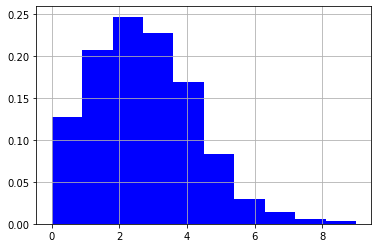

In [486]:
v_normal = v_adr['adr']
v_normal = 9*(v_normal - v_normal.min())/\
            (v_normal.max() - v_normal.min())
v_normal.hist(density= True,bins=10,cumulative=0,color='b')


<AxesSubplot:>

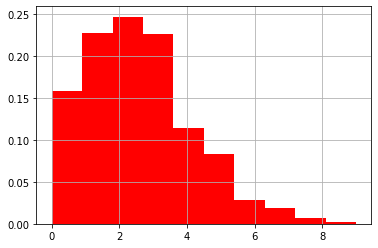

In [487]:
inv_normal = inv_adr['adr']
inv_normal = 9*(inv_normal - inv_normal.min())/\
            (inv_normal.max() - inv_normal.min())

inv_normal.hist(density= True,bins=10,cumulative=0,color='r')

## Sum( adr $\times$ date_range) by date

- **valid**: no neg. date
- **invalid**: with neg. date

In [488]:
invalid_x , valid_x = deepcopy(df_x),deepcopy(df_x)
valid_x = valid_x.loc[valid_x['is_canceled']==0,:].reset_index(drop=True)
valid_x['adr'] = valid_x['adr'].apply(lambda x: max(0,x))



# date_range_v = (valid_x['reservation_status_date']-valid_x['arrival_date'])\
#             .apply(lambda x : x.days)

# date_range_inv = (invalid_x['reservation_status_date']-invalid_x['arrival_date'])\
#             .apply(lambda x : x.days)
# valid_x['date_range']=date_range_v
# valid_x['date_range']=valid_x['date_range'].apply(lambda x: 0 if x<=0 else x)
valid_x['sum_adr'] = valid_x['stay_days']*valid_x['adr']

# invalid_x['date_range']=date_range_inv
invalid_x['sum_adr'] = invalid_x['stay_days']*invalid_x['adr']

In [489]:
v_sumadr = valid_x.groupby('arrival_date').sum()[['sum_adr']]
inv_sumadr = invalid_x.groupby('arrival_date').sum()[['sum_adr']]
# v_adr = valid_x.groupby('arrival_date').mean()[['adr']]
# inv_adr = invalid_x.groupby('arrival_date').mean()[['adr']]


<AxesSubplot:>

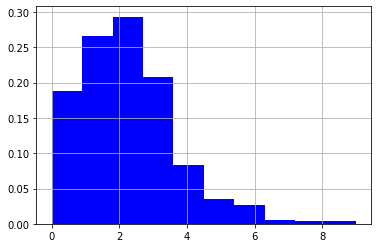

In [490]:
vsum_normal = v_sumadr['sum_adr']
vsum_normal = 9*(vsum_normal - vsum_normal.min())/\
            (vsum_normal.max() - vsum_normal.min())
vsum_normal.hist(density= True,bins=10,cumulative=0,color='b')


In [492]:
invsum_normal

arrival_date
2015-07-01    1.865014
2015-07-02    1.545745
2015-07-03    1.208752
2015-07-04    1.635575
2015-07-05    1.835166
                ...   
2017-03-27    2.461691
2017-03-28    1.513079
2017-03-29    2.252236
2017-03-30    3.112044
2017-03-31    3.392575
Name: sum_adr, Length: 640, dtype: float64

<AxesSubplot:>

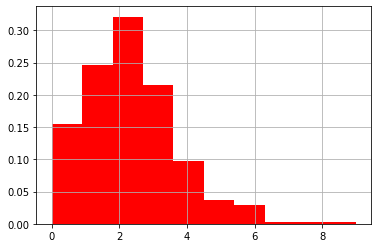

In [499]:
invsum_normal = inv_sumadr['sum_adr']
invsum_normal = 9*(invsum_normal - invsum_normal.min())/\
            (invsum_normal.max() - invsum_normal.min())

invsum_normal.hist(density= True,bins=10,cumulative=0,color='r')

## True $x$ label distribuion

<AxesSubplot:>

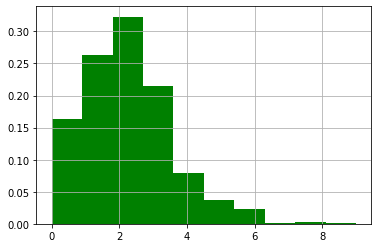

In [494]:
df_y['label'].hist(density=True , bins=10 ,cumulative=0 , color='g')

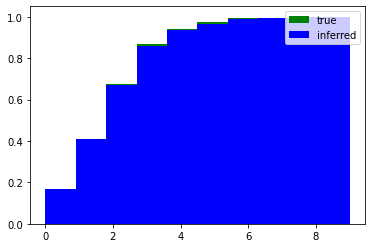

In [497]:
infer_label = vsum_normal.values
# infer_label = invsum_normal.values
true_label = df_y['label']
plt.hist(true_label , 
        density=True,
         cumulative=1 ,
         bins=10,
         color='green',
        label='true')
plt.hist(infer_label ,
         density=True,
         cumulative=1 ,
         bins=10,
         color='blue',
        label='inferred')


plt.legend(loc='upper right')
plt.show()

In [498]:
abs(infer_label - true_label).sum()/len(infer_label)

0.3123135872507655

In [24]:
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, SVC
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score , f1_score , recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, LeaveOneOut
from sklearn.preprocessing import StandardScaler 

from sklearn.multiclass import OneVsRestClassifier as OVR

## From normalized_adr to label

In [324]:
x, y = infer_label, true_label.values
x, y = x.reshape(-1 ,1) , y.reshape(-1,1)
test_size = 300 # from 640

### Linear Regression

In [325]:
model_lr = LinearRegression(normalize=False)
model_lr = OVR(model_lr)
model_lr.fit(x[:test_size,:] , y[:test_size,:])


OneVsRestClassifier(estimator=LinearRegression())

In [266]:
y_pred = model_lr.predict(x[test_size:,:])
mae(y[test_size:,:] , y_pred)

0.861764705882353

### SVR

In [326]:
model_svr = SVC(C=10)
# model_svr = OVR(model_svr)
model_svr.fit(x[:test_size,:] , y[:test_size,:].flatten())


SVC(C=10)

In [327]:
y_pred = model_lr.predict(x[test_size:,:])
mae(y[test_size:,:].flatten() , y_pred)

0.861764705882353

### LGB

In [328]:
from lightgbm import LGBMClassifier

model_lgb = LGBMClassifier(num_class =10 ,
                           objective='multiclass',
                           metric='multi_logloss')
model_lgb.fit(x[:test_size,:] , y[:test_size,:].flatten())

LGBMClassifier(metric='multi_logloss', num_class=10, objective='multiclass')

In [329]:
y_pred = model_lgb.predict(x[test_size:,:])
mae(y[test_size:,:].flatten() , y_pred)

0.08823529411764706

In [72]:
import joblib
# from sklearn.model_selection import GridSearchCV 

# parameters ={
#     'max_leaf': [100 , 200, 300 ,400 , 600],
#     'max_depth': [2, 5 ,10 , 15, 20,  35],
#     'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.15],
#     'feature_fraction': [0.6, 0.7, 0.8, 0.95],
#     'bagging_fraction': [0.6, 0.7, 0.8, 0.95],
#     'bagging_freq': [2, 4, 6, 8],
#     'lambda_l1': [0.1, 0.4, 0.6],
#     'lambda_l2': [10, 15, 35],
#     'cat_smooth': [1, 10, 15, 20, 35],
#     }
# gs = GridSearchCV(model_lgb , 
#                   param_grid =parameters , 
#                   n_jobs = 20)
# gs.fit(x[:test_size,:] , y[:test_size,:].flatten())
# gs.best_params_
gs_ = joblib.load("gs_model_yy")

In [253]:
model =  gs_.estimator
params = gs_.best_params_

In [254]:
# model
params

{'bagging_fraction': 0.95,
 'bagging_freq': 2,
 'cat_smooth': 1,
 'feature_fraction': 0.6,
 'lambda_l1': 0.1,
 'lambda_l2': 10,
 'learning_rate': 0.15,
 'max_depth': 2,
 'max_leaf': 100}

In [255]:
model.set_params(**params)

LGBMClassifier(bagging_fraction=0.95, bagging_freq=2, cat_smooth=1,
               feature_fraction=0.6, lambda_l1=0.1, lambda_l2=10,
               learning_rate=0.15, max_depth=2, max_leaf=100,
               metric='multi_logloss', num_class=10, objective='multiclass')

In [256]:
model.fit(x[:test_size,:] , y[:test_size,:].flatten())

[LightGBM] [Warning] lambda_l2 is set=10, reg_lambda=0.0 will be ignored. Current value: lambda_l2=10
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] num_leaves is set=31, max_leaf=100 will be ignored. Current value: num_leaves=31
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.95, subsample=1.0 will be ignored. Current value: bagging_fraction=0.95
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


LGBMClassifier(bagging_fraction=0.95, bagging_freq=2, cat_smooth=1,
               feature_fraction=0.6, lambda_l1=0.1, lambda_l2=10,
               learning_rate=0.15, max_depth=2, max_leaf=100,
               metric='multi_logloss', num_class=10, objective='multiclass')

In [257]:
y_pred = model.predict(x[test_size:,:])
mae(y[test_size:,:].flatten() , y_pred)

0.24259259259259258

In [295]:
import pickle 
with open('yy.pickle', 'wb') as f:
    pickle.dump([x[:test_size,:] , y[:test_size,:].flatten()] ,f)
    

In [296]:
with open('yy.pickle' ,'rb') as f:
    x_train , y_train  =  pickle.load(f)

In [ ]:
y_pred = model_lgb.predict(x[test_size:,:])
mae(y[test_size:,:].flatten() , y_pred)

## Remaining Feature for ADR

In [179]:
remain_cols=[\
            'lead_time',
            'stays_in_weekend_nights', 
            'stays_in_week_nights',
            'adults', 
            'children',
            'babies', 
#             'meal',
#             'country',
#             'market_segment',
#             'distribution_channel',
            'is_repeated_guest', 
            'previous_cancellations',
            'previous_bookings_not_canceled',
#             'reserved_room_type',
#             'assigned_room_type', 
            'booking_changes',
#             'deposit_type',
            'agent',
            'company',
            'days_in_waiting_list',
#             'customer_type',
            'required_car_parking_spaces', 
            'total_of_special_requests',
              ]


In [171]:
valid_x_sum = valid_x.groupby('arrival_date').sum()

In [176]:
valid_x_sum.columns

Index(['ID', 'is_canceled', 'lead_time', 'arrival_date_week_number',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies', 'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'booking_changes', 'agent', 'company',
       'days_in_waiting_list', 'adr', 'required_car_parking_spaces',
       'total_of_special_requests', 'date_range', 'sum_adr'],
      dtype='object')

array([[<AxesSubplot:title={'center':'lead_time'}>,
        <AxesSubplot:title={'center':'stays_in_weekend_nights'}>],
       [<AxesSubplot:title={'center':'stays_in_week_nights'}>,
        <AxesSubplot:title={'center':'adults'}>]], dtype=object)

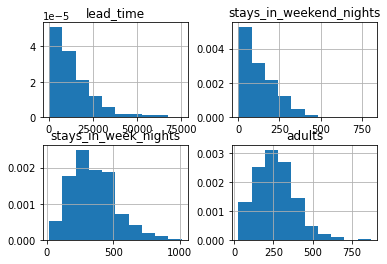

In [183]:
valid_x_sum[remain_cols[:4]].hist(bins=10,density=True)

array([[<AxesSubplot:title={'center':'children'}>,
        <AxesSubplot:title={'center':'babies'}>],
       [<AxesSubplot:title={'center':'is_repeated_guest'}>,
        <AxesSubplot:title={'center':'previous_cancellations'}>]],
      dtype=object)

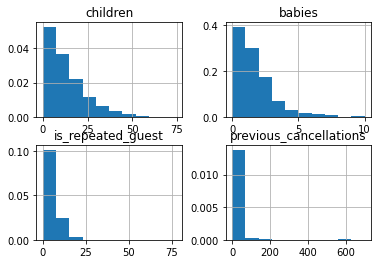

In [184]:
valid_x_sum[remain_cols[4:8]].hist(bins=10,density=True)

array([[<AxesSubplot:title={'center':'previous_bookings_not_canceled'}>,
        <AxesSubplot:title={'center':'booking_changes'}>],
       [<AxesSubplot:title={'center':'agent'}>,
        <AxesSubplot:title={'center':'company'}>]], dtype=object)

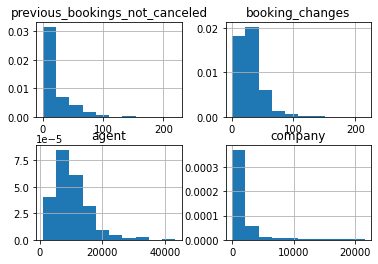

In [185]:
valid_x_sum[remain_cols[8:12]].hist(bins=10,density=True)

array([[<AxesSubplot:title={'center':'days_in_waiting_list'}>,
        <AxesSubplot:title={'center':'required_car_parking_spaces'}>],
       [<AxesSubplot:title={'center':'total_of_special_requests'}>,
        <AxesSubplot:>]], dtype=object)

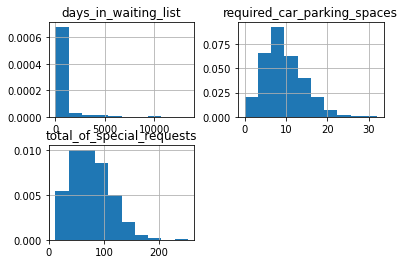

In [186]:
valid_x_sum[remain_cols[12:]].hist(bins=10,density=True)

In [187]:
remain_cols

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'agent',
 'company',
 'days_in_waiting_list',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [191]:
def histogram_intersection(a, b):
    v = np.minimum(a, b).sum().round(decimals=1)
    return v


valid_x_sum['lead_time'].corr(true_label, method='pearson')

nan

In [313]:
remain_x_y = deepcopy(valid_x_sum[remain_cols])
remain_x_y['label']=true_label.values
remain_x_y = remain_x_y[['label']+remain_cols]
# .corr(method='pearson')


In [314]:
((remain_x_y.corr(method='pearson')**2)**.5)\
            .sort_values('label',ascending=False)

,label,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
label,1.000000,0.513087,0.633663,0.556352,0.637922,0.624413,0.347326,0.181930,0.012054,0.120508,0.409913,0.432488,0.076464,0.097123,0.458513,0.626447
adults,0.637922,0.809737,0.524372,0.826537,1.000000,0.439049,0.185092,0.016638,0.116263,0.039203,0.549339,0.624377,0.155262,0.271310,0.480812,0.636411
stays_in_weekend_nights,0.633663,0.342950,1.000000,0.242447,0.524372,0.375137,0.275103,0.186849,0.048385,0.148287,0.259763,0.442653,0.111548,0.028835,0.272680,0.458020
total_of_special_requests,0.626447,0.464766,0.458020,0.537144,0.636411,0.600007,0.270889,0.030378,0.112144,0.029098,0.423111,0.490732,0.001201,0.068228,0.485960,1.000000
children,0.624413,0.274927,0.375137,0.348007,0.439049,1.000000,0.340986,0.153325,0.101387,0.104211,0.342271,0.338233,0.108282,0.013109,0.487390,0.600007
stays_in_week_nights,0.556352,0.752619,0.242447,1.000000,0.826537,0.348007,0.112213,0.084009,0.105784,0.102751,0.557976,0.564633,0.240636,0.287191,0.431735,0.537144
lead_time,0.513087,1.000000,0.342950,0.752619,0.809737,0.274927,0.094193,0.083254,0.128481,0.088290,0.507240,0.449613,0.146675,0.323660,0.307095,0.464766
required_car_parking_spaces,0.458513,0.307095,0.272680,0.431735,0.480812,0.487390,0.225466,0.006595,0.086548,0.066465,0.383784,0.401743,0.151457,0.094161,1.000000,0.485960
agent,0.432488,0.449613,0.442653,0.564633,0.624377,0.338233,0.151318,0.014482,0.017619,0.005433,0.385253,1.000000,0.010146,0.121016,0.401743,0.490732
booking_changes,0.409913,0.507240,0.259763,0.557976,0.549339,0.342271,0.130197,0.009156,0.056233,0.044632,1.000000,0.385253,0.331493,0.141522,0.383784,0.423111


In [315]:
((remain_x_y.corr(method='pearson')**1)**1)\
            .sort_values('label',ascending=False)

,label,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
label,1.000000,0.513087,0.633663,0.556352,0.637922,0.624413,0.347326,-0.181930,-0.012054,-0.120508,0.409913,0.432488,-0.076464,0.097123,0.458513,0.626447
adults,0.637922,0.809737,0.524372,0.826537,1.000000,0.439049,0.185092,-0.016638,0.116263,-0.039203,0.549339,0.624377,0.155262,0.271310,0.480812,0.636411
stays_in_weekend_nights,0.633663,0.342950,1.000000,0.242447,0.524372,0.375137,0.275103,-0.186849,0.048385,-0.148287,0.259763,0.442653,-0.111548,0.028835,0.272680,0.458020
total_of_special_requests,0.626447,0.464766,0.458020,0.537144,0.636411,0.600007,0.270889,-0.030378,-0.112144,0.029098,0.423111,0.490732,-0.001201,0.068228,0.485960,1.000000
children,0.624413,0.274927,0.375137,0.348007,0.439049,1.000000,0.340986,-0.153325,-0.101387,-0.104211,0.342271,0.338233,-0.108282,0.013109,0.487390,0.600007
stays_in_week_nights,0.556352,0.752619,0.242447,1.000000,0.826537,0.348007,0.112213,0.084009,0.105784,0.102751,0.557976,0.564633,0.240636,0.287191,0.431735,0.537144
lead_time,0.513087,1.000000,0.342950,0.752619,0.809737,0.274927,0.094193,-0.083254,0.128481,-0.088290,0.507240,0.449613,0.146675,0.323660,0.307095,0.464766
required_car_parking_spaces,0.458513,0.307095,0.272680,0.431735,0.480812,0.487390,0.225466,0.006595,-0.086548,0.066465,0.383784,0.401743,0.151457,0.094161,1.000000,0.485960
agent,0.432488,0.449613,0.442653,0.564633,0.624377,0.338233,0.151318,0.014482,0.017619,0.005433,0.385253,1.000000,0.010146,0.121016,0.401743,0.490732
booking_changes,0.409913,0.507240,0.259763,0.557976,0.549339,0.342271,0.130197,0.009156,-0.056233,0.044632,1.000000,0.385253,0.331493,0.141522,0.383784,0.423111


In [317]:
related_cols= [ 
        'adults',
        'stays_in_weekend_nights',
        'total_of_special_requests',
        'children',
        'stays_in_week_nights',
        'lead_time',
        'required_car_parking_spaces',
        'agent',
        'booking_changes',
        'babies'] 
related_x = remain_x_y[related_cols]

## Remaining feature for Stay_days

In [46]:
valid_x = deepcopy(df_x)
# valid_x = valid_x.loc[valid_x['is_canceled']==0,:].reset_index(drop=True)
# valid_x['adr'] = abs(valid_x['adr'])
# valid_x['adr'] = valid_x['adr'].apply(lambda x: max(0,x))



In [50]:
date_related_cols = [ 
                    'stay_days',
                    'hotel', 
#                     'is_canceled',
                    'lead_time',
                    'arrival_date_week_number',
                    'stays_in_weekend_nights', 
                    'stays_in_week_nights',
                    'adults',
                    'children',
                    'babies', 
                    'meal',
                    'country',
                    'market_segment',
                    'distribution_channel',
                    'is_repeated_guest', 
                    'previous_cancellations',
                    'previous_bookings_not_canceled', 
                    'reserved_room_type',
                    'assigned_room_type', 
                    'booking_changes', 
                    'deposit_type',
                    'agent',
                    'company', 
                    'days_in_waiting_list', 
                    'customer_type', 
#                     'adr',
                    'required_car_parking_spaces',
                    'total_of_special_requests',
#                     'reservation_status',
#                     'reservation_status_date',
                    'arrival_date', 
#                     'sum_adr'
]

In [51]:
date_related = valid_x[date_related_cols]

((date_related.corr(method='pearson')**2)**.5)\
            .sort_values('stay_days',ascending=False)

,stay_days,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
stay_days,1.000000,0.054806,0.008990,0.493316,0.591092,0.043852,0.011899,0.027962,0.052972,0.085501,0.013274,0.176687,0.156025,0.011216,0.043557,0.094056,0.191755
stays_in_week_nights,0.591092,0.145017,0.015237,0.517161,1.000000,0.084698,0.036939,0.016841,0.103593,0.011113,0.050100,0.103896,0.187774,0.037305,0.001383,0.026595,0.068818
stays_in_weekend_nights,0.493316,0.057351,0.022775,1.000000,0.517161,0.089761,0.040300,0.017438,0.092898,0.009460,0.041479,0.073775,0.150099,0.071796,0.058431,0.018331,0.075139
total_of_special_requests,0.191755,0.137366,0.031282,0.075139,0.068818,0.122553,0.089910,0.104010,0.001424,0.056001,0.029086,0.040245,0.067079,0.092341,0.088337,0.083928,1.000000
booking_changes,0.176687,0.016268,0.004075,0.073775,0.103896,0.051519,0.048040,0.080451,0.009094,0.030735,0.013024,1.000000,0.032488,0.096162,0.013164,0.060834,0.040245
agent,0.156025,0.060550,0.017567,0.150099,0.187774,0.018516,0.039087,0.029710,0.054154,0.015396,0.046498,0.032488,1.000000,0.119147,0.044693,0.123260,0.067079
required_car_parking_spaces,0.094056,0.117076,0.002775,0.018331,0.026595,0.016953,0.063271,0.032005,0.068502,0.023007,0.043570,0.060834,0.123260,0.034371,0.035900,1.000000,0.083928
previous_cancellations,0.085501,0.111519,0.029807,0.009460,0.011113,0.000663,0.025354,0.008460,0.073088,1.000000,0.128712,0.030735,0.015396,0.006418,0.002727,0.023007,0.056001
lead_time,0.054806,1.000000,0.155992,0.057351,0.145017,0.114516,0.060126,0.025167,0.117214,0.111519,0.071374,0.016268,0.060550,0.073823,0.205704,0.117076,0.137366
is_repeated_guest,0.052972,0.117214,0.036474,0.092898,0.103593,0.137987,0.031516,0.009471,1.000000,0.073088,0.413832,0.009094,0.054154,0.145311,0.025981,0.068502,0.001424


In [404]:
top_related_cols = ['lead_time',
                    'total_of_special_requests',
                    'previous_cancellations',
                    'agent',
                    'required_car_parking_spaces',
                    'booking_changes']

In [402]:
((date_related.corr(method='pearson')))\
            .sort_values('date_range',ascending=False)

,date_range,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,agent,company,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests
date_range,1.000000,-0.619249,-0.070563,0.080944,0.009283,-0.071434,0.036163,0.023896,0.020217,-0.140024,0.036299,0.113867,0.125809,0.005578,-0.050100,0.114044,0.210708
total_of_special_requests,0.210708,-0.137366,0.031282,0.075139,0.068818,0.122553,0.089923,0.104010,0.001424,-0.056001,0.029086,0.040245,0.043028,-0.085697,-0.088337,0.083928,1.000000
agent,0.125809,-0.125697,-0.031241,0.126642,0.173179,-0.039348,0.030731,0.036703,0.024725,-0.011313,0.021735,0.068828,1.000000,0.430367,-0.062414,0.186292,0.043028
required_car_parking_spaces,0.114044,-0.117076,-0.002775,-0.018331,-0.026595,0.016953,0.063268,0.032005,0.068502,-0.023007,0.043570,0.060834,0.186292,-0.010881,-0.035900,1.000000,0.083928
booking_changes,0.113867,-0.016268,0.004075,0.073775,0.103896,-0.051519,0.048037,0.080451,0.009094,-0.030735,0.013024,1.000000,0.068828,0.129543,-0.013164,0.060834,0.040245
stays_in_weekend_nights,0.080944,0.057351,0.022775,1.000000,0.517161,0.089761,0.040299,0.017438,-0.092898,-0.009460,-0.041479,0.073775,0.126642,0.097765,-0.058431,-0.018331,0.075139
previous_bookings_not_canceled,0.036299,-0.071374,-0.026496,-0.041479,-0.050100,-0.104113,-0.020664,-0.006843,0.413832,0.128712,1.000000,0.013024,0.021735,-0.203653,-0.011044,0.043570,0.029086
children,0.036163,-0.060137,-0.000639,0.040299,0.036938,0.030126,1.000000,0.027086,-0.031518,-0.025355,-0.020664,0.048037,0.030731,0.035497,-0.034799,0.063268,0.089923
babies,0.023896,-0.025167,0.009022,0.017438,0.016841,0.019994,0.027086,1.000000,-0.009471,-0.008460,-0.006843,0.080451,0.036703,0.024929,-0.012222,0.032005,0.104010
is_repeated_guest,0.020217,-0.117214,-0.036474,-0.092898,-0.103593,-0.137987,-0.031518,-0.009471,1.000000,0.073088,0.413832,0.009094,0.024725,-0.237287,-0.025981,0.068502,0.001424


In [452]:
date_related.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91531 entries, 0 to 91530
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   date_range                      91531 non-null  int64         
 1   hotel                           91531 non-null  object        
 2   lead_time                       91531 non-null  int64         
 3   arrival_date_week_number        91531 non-null  int64         
 4   stays_in_weekend_nights         91531 non-null  int64         
 5   stays_in_week_nights            91531 non-null  int64         
 6   adults                          91531 non-null  int64         
 7   children                        91527 non-null  float64       
 8   babies                          91531 non-null  int64         
 9   meal                            91531 non-null  object        
 10  country                         91063 non-null  object        
 11  ma

In [21]:
from torch import optim
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable

## Loader

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


class Loader:
    def __init__(self, x,y, batch_size , device):
        self.device = device
        self.x=x
        self.y=y
        self.num = len(y)
        self.bsize= batch_size
    def get_batch(self):
        index = np.random.randint(0 , self.num , self.bsize)
        return  self.cuda(self.x[index] ,self.y[index])
        
    def cuda(self , x,y):
        x = Variable(torch.FloatTensor(x))
        y = Variable(torch.FloatTensor(y))
        return x.to(self.device) ,y.to(self.device)
    
    def get_val(self):
        return self.cuda(self.x,  self.y)

class TwoPhaseLoader:
    def __init__(self, df ,df_test = None, device = 'cuda'):
        self.sc = StandardScaler()
        self.test = df_test
        self.device = device
        self.date_unique = df['arrival_date'].unique()
        self.x=df.drop(['adr' , 'is_canceled' , 'stay_days' , 'label'] , axis=1)
        self.y=df[['arrival_date','adr' , 'is_canceled' , 'stay_days' , 'label']]
        self.feature_cols = deepcopy(self.x.columns)
        self.num = len(self.y)
        
        date_id = self.get_date_ids(self.y[['arrival_date']])
        self.df_date_id = deepcopy(self.y[['arrival_date']])
        self.df_date_id['date_id'] = date_id
        
        
    def get_batch(self, n_day = 3,  get_all = False):
        # Unique random int
        index = np.arange(0, n_day)
        np.random.shuffle(index)
        selected_date = self.date_unique[index]
        print('select ' , selected_date)
        
        if get_all:
            batch_x = self.x.drop('arrival_date',axis=1).values
            batch_y = self.y.drop('arrival_date',axis=1).values

        
        batch_x = self.x[self.x['arrival_date'].apply(lambda x: x in selected_date)]\
                                               .drop('arrival_date',axis=1).values
        batch_y = self.y[self.y['arrival_date'].apply(lambda x: x in selected_date)]\
                                               .drop('arrival_date',axis=1).values
        batch_date_id = self.df_date_id[self.df_date_id['arrival_date']\
                                        .apply(lambda x: x in selected_date)][['date_id']]
        batch_agg_matrix = self.agg_matrix(batch_date_id)
        """ x: np [feature]
            y: np ['adr' , 'is_canceled' , 'stay_days' , 'label']
        """
        return  self.cuda(batch_agg_matrix, batch_x,  batch_y )
        
    def cuda(self , agg_matrix,x,y):
#         agg_matrix = torch.FloatTensor(agg_matrix)
        x = Variable(torch.FloatTensor(x))
        y = Variable(torch.FloatTensor(y))
        
        return agg_matrix.to(self.device),\
                x.to(self.device) ,\
                y.to(self.device)
    
    def get_test(self):
        if self.test is None:
            print('no testing data')
        test_data = self.test.drop('arrival_date' , axis=1).values
        test_data = self.sc.transform(test_data)
        return torch.FloatTensor(test_data).to(self.device)  
    
    def scale(self):
        tmp_x=self.x.drop('arrival_date', axis=1)
        x=self.sc.fit_transform(tmp_x.values)
        tmp_x =pd.DataFrame(x ,
                            index = tmp_x.index ,
                            columns = tmp_x.columns)
        self.x = pd.concat([self.x['arrival_date'] , tmp_x]  ,axis=1)
        print('rescale x')
    def scale_val(self, sc):
        tmp_x=self.x.drop('arrival_date', axis=1)
        x=sc.transform(tmp_x.values)
        tmp_x =pd.DataFrame(x ,
                            index = tmp_x.index ,
                            columns = tmp_x.columns)
        self.x = pd.concat([self.x['arrival_date'] , tmp_x]  ,axis=1)
        print('rescale val x')
    
    def get_date_ids(self, df_date):
        date_unique = df_date['arrival_date'].apply(str).unique()
        date_dict = dict(zip(date_unique, [i for i in range(len(date_unique))]))
        return df_date['arrival_date'].apply(lambda x: date_dict[str(x)]).values
        
    def agg_matrix(self, batch_date_id):
        batch_size= batch_date_id.shape[0]
#         date_unique = batch_date['date_id'].unique()
        print(batch_date_id['date_id'].max(),batch_size)
        agg_matrix = torch.zeros(int(batch_date_id['date_id'].max())+1,\
                                 batch_size)
        agg_matrix[batch_date_id['date_id'].values,\
                   torch.arange(batch_size)] =1
        return agg_matrix
        
        

Using device: cuda


## 4 Nets

In [23]:
nn_x = df_can.drop('arrival_date' , axis=1).values
nn_y = np.concatenate([can_y.reshape( -1, 1) ,
                       adr_y.reshape(-1 ,1) ,
                       day_y.reshape(-1 ,1)] , axis=1)


In [24]:
nn_x.shape

(91531, 243)

In [25]:
nn_y

array([[ 0.        , -6.30516084,  0.        ],
       [ 0.        , 75.05222697,  2.        ],
       [ 0.        , 74.54640111,  2.        ],
       ...,
       [ 0.        , 90.81455355,  1.        ],
       [ 0.        , 38.1355651 , 10.        ],
       [ 0.        , 58.19647044,  1.        ]])

In [35]:
from sklearn.preprocessing import StandardScaler
scx = StandardScaler()
scy = StandardScaler()

In [36]:
nn_x_train, nn_x_val , nn_y_train , nn_y_val = train_test_split(nn_x ,nn_y , test_size = .5)

scx.fit(nn_x_train)
scy.fit(nn_y_train)
x_train_sc = scx.transform(nn_x_train)
y_train_sc = scy.transform(nn_y_train)
x_val_sc=scx.transform(nn_x_val)
y_val_sc = scy.transform(nn_y_val)

# x_train_sc , x_val_sc ,y_train_sc , y_val_sc = nn_x_train,\
#                                                 nn_x_val ,\
#                                                 nn_y_train ,\
#                                                 nn_y_val

# x_train_sc , x_val_sc = DR(x_train_sc , x_val_sc)
# x_train_sc , y_train_sc = data_augmentor(x_train_sc, y_train_sc, times = 3, sigma=0.1, balance=True)


# train_loader = Loader(x_train_sc , y_train_sc, 64 ,device)
# test_loader = Loader(x_val_sc , y_val_sc ,64 , device)


## join model from here

In [26]:



df_merged =df_can.merge(df_y  ,how='left',left_on ='arrival_date', right_on = 'arrival_date')
y_merged = pd.DataFrame({  'is_canceled':can_y ,
                           'adr':adr_y ,
                           'stay_days': day_y})
df_merged = pd.concat([df_merged , y_merged] , axis =1)
df_merged_train , df_merged_val = train_test_split(df_merged , test_size = .5)


all_loader = TwoPhaseLoader(df_merged , df_can_t,  device)
train_loader= TwoPhaseLoader(df_merged_train  ,device)
val_loader = TwoPhaseLoader(df_merged_val  ,device)


all_loader.scale()
train_loader.scale()
val_loader.scale_val(train_loader.sc)

NameError: name 'TwoPhaseLoader' is not defined

In [59]:
b = val_loader.get_batch(n_day=1)
(b[0].shape , b[1].shape , b[2].shape)
# val_loader.df_date_id

select  ['2015-10-24T00:00:00.000000000']
0 81


(torch.Size([1, 81]), torch.Size([81, 243]), torch.Size([81, 4]))

array([[<AxesSubplot:title={'center':'adr'}>]], dtype=object)

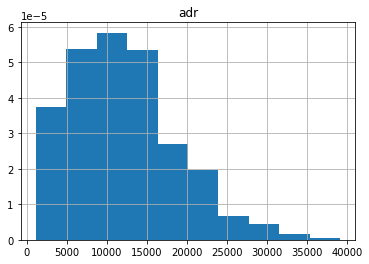

In [90]:
y_3[['adr']].hist(density=True)

In [165]:
class AGGNet(nn.Module):
    def __init__(self,input_dim , output_dim):
        super().__init__()
        self.w_1=nn.Linear(input_dim , 1000)
        self.bn_1=nn.BatchNorm1d(1000)
        self.w_2=nn.Linear(1000 , 500)
        self.bn_2=nn.BatchNorm1d(500)
        self.w_3=nn.Linear(500 , 250)
        self.bn_3=nn.BatchNorm1d(250)
        self.w_4=nn.Linear(250 , 70)
        self.bn_4=nn.BatchNorm1d(70)
        self.output=nn.Linear(70 , output_dim)
        self.sf = nn.LogSoftmax(dim=1)
        
        self.dr_1 = nn.Dropout(.4)
        self.dr_2 = nn.Dropout(.4)
        self.dr_3 = nn.Dropout(.4)
        self.dr_4 = nn.Dropout(.4)

    def forward(self, x):
        x=F.relu(self.w_1(x))
        x=self.dr_1(x)
        x=self.bn_1(x)
        x=F.relu(self.w_2(x))
        x=self.dr_2(x)
        x=self.bn_2(x)
        x=F.relu(self.w_3(x))
        x=self.dr_3(x)
        x=self.bn_3(x)
        x=F.relu(self.w_4(x))
        x=self.dr_4(x)
        x=self.bn_4(x)
        x=self.output(x)
        return self.sf(x)
    
    
net=AGGNet(x_group.shape[1],10)

In [166]:
net

AGGNet(
  (w_1): Linear(in_features=244, out_features=1000, bias=True)
  (bn_1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (w_2): Linear(in_features=1000, out_features=500, bias=True)
  (bn_2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (w_3): Linear(in_features=500, out_features=250, bias=True)
  (bn_3): BatchNorm1d(250, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (w_4): Linear(in_features=250, out_features=70, bias=True)
  (bn_4): BatchNorm1d(70, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=70, out_features=10, bias=True)
  (sf): LogSoftmax(dim=1)
  (dr_1): Dropout(p=0.4, inplace=False)
  (dr_2): Dropout(p=0.4, inplace=False)
  (dr_3): Dropout(p=0.4, inplace=False)
  (dr_4): Dropout(p=0.4, inplace=False)
)

In [163]:



x_group = df_merged.groupby('arrival_date').sum()
x_group['label'] = df_merged.groupby('arrival_date')['label'].first().values
y_3 = x_group[['label' , 'adr' , 'stay_days' , 'is_canceled']]
x_group = x_group.drop(['label' , 'adr' , 'stay_days' , 'is_canceled'] , axis=1)

x_group_t = df_can_t.groupby('arrival_date').sum()


aug_x , aug_y = data_augmentor(x_group.values , y_3[['label']] , times=10 , df=False)
print((aug_x.shape,  aug_y.shape))


x_train , x_val , y_train , y_val = train_test_split(aug_x, \
                                                   aug_y, test_size = .5, stratify=aug_y)


# x_train , x_val , y_train , y_val = train_test_split(x_group.values, \
#                                                     y_3[['label']].values, test_size = .1, stratify=y_3['label'])

y_train , y_val =y_train.ravel() , y_val.ravel()
x_train=torch.FloatTensor(x_train).to(device)
x_val = torch.FloatTensor(x_val).to(device)
y_train=torch.LongTensor(y_train).to(device)
y_val=torch.LongTensor(y_val).to(device)

original shape:  (640, 244)
balanced shape:  (1880, 244)
augmented shape: (20680, 244)
((20680, 244), (20680, 1))


In [167]:
net.train()
net.to(device)


criterion = nn.CrossEntropyLoss()
# criterion= nn.NLLLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-8)



his_los = []
his_val_los = []

for epoch in range(1, 10000):
    optimizer.zero_grad()
    y_pred = net(x_train)
    
    loss = criterion(y_pred, y_train)
    loss.backward()
    optimizer.step() 

    y_pred_val = net(x_val)
    loss_val = criterion( y_pred_val , y_val)
    los , val_los =loss.cpu().data, loss_val.cpu().data
    if epoch%300 == 1:
        
        his_los.append(los.numpy().tolist())
        his_val_los.append(val_los.numpy().tolist())
    if (epoch % 1000 == 1) :
        maeloss= mae(torch.argmax(y_pred_val , axis=1).cpu().data , y_val.cpu().data)
        print('epoch: %3d , loss: %2.4f, val_loss %2.4f, val_mae %2.4f'%(epoch,los , val_los ,maeloss ))
        

        
y_pred = net(x_val).cpu().data
mae(torch.argmax(y_pred , axis=1) , y_val.cpu().data)
# loss = criterion(y_pred, y_total_val)bb
# print('validation loss' , loss.cpu().detach().numpy())

epoch:   1 , loss: 2.4632, val_loss 2.4485, val_mae 3.4094
epoch: 1001 , loss: 2.4564, val_loss 2.4569, val_mae 3.4361
epoch: 2001 , loss: 2.4490, val_loss 2.4530, val_mae 3.4108
epoch: 3001 , loss: 2.4387, val_loss 2.4476, val_mae 3.3861
epoch: 4001 , loss: 2.4340, val_loss 2.4478, val_mae 3.3803
epoch: 5001 , loss: 2.4300, val_loss 2.4372, val_mae 3.3774
epoch: 6001 , loss: 2.4356, val_loss 2.4406, val_mae 3.3525
epoch: 7001 , loss: 2.4287, val_loss 2.4269, val_mae 3.3643
epoch: 8001 , loss: 2.4352, val_loss 2.4326, val_mae 3.3322
epoch: 9001 , loss: 2.4216, val_loss 2.4193, val_mae 3.3011


3.3271760154738876

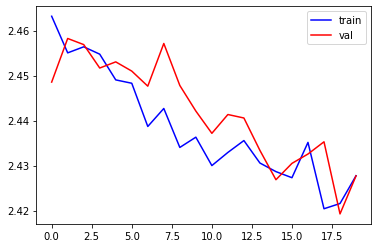

In [168]:
plt.plot(his_los , label = 'train', color=  'blue')
plt.plot(his_val_los , label ='val' , color= 'red')
plt.legend(loc='upper right')
# plt.yscale('log')
plt.show()

In [147]:
y_train.shape

torch.Size([2820, 1])

In [48]:
mae(torch.argmax(y_pred , axis=1) , y_val.cpu().data)

0.6091876208897485

In [138]:
torch.save(net , 'net_model_3.pt')

In [139]:
n1 = torch.load('net_model_3.pt').cpu()

In [56]:
x_test = torch.FloatTensor(x_group_t.values)


# n1()



In [105]:
pre_test = torch.argmax(n1(x_test) , axis=1).numpy()

In [140]:
pre_test3 = torch.argmax(n1(x_test) , axis=1).numpy()

## AggNet 2

In [179]:

def data_augmentor_aggnet2(df_mer, y_4, sigma=0.1, times=10, balance = True, df=False):
    
    
    df_mer = pd.concat([df_mer[['date_id']] , df_mer.drop('date_id' ,axis=1)]  ,axis=1)
    
    x_g = deepcopy(df_mer.values)
    y_g = deepcopy(y_4.values)
    
    # for dropped
    x_ = deepcopy(df_mer)
    y_ = deepcopy(y_4)
    
    x_date = x_[['date_id']].values
    x_ = x_.drop('date_id' , axis=1).values
    y_ = y_.label.values
    
    print('original shape: ', x_g.shape)
    if balance:
        y_flat = y_.ravel()
        most_count_per_class= max([v for k,v in Counter(y_flat).items()])
        hope_num_per_class = most_count_per_class + 2

        class_id_map ={}
        for i,v in enumerate(y_flat):
            if class_id_map.get(v , None) == None:
                class_id_map[v]=[]
            class_id_map[v].append(i)
        for k,v in class_id_map.items():
            class_id_map[k] = np.array(v)
            
        all_selected_index = []

        for cla,id_list in class_id_map.items():
            num_to_gene = hope_num_per_class - len(id_list)
            selected_index_of_list = np.random.randint(0, len(id_list) ,num_to_gene)
            selected_index_of_row = id_list[selected_index_of_list]

            all_selected_index = all_selected_index + selected_index_of_row.tolist()
            
        x_noise = np.random.normal(0 , sigma , (len(all_selected_index) ,x_.shape[1]))
        
        x_for_balance = deepcopy(x_[all_selected_index ,:])+x_noise
        y_for_balance = deepcopy(y_g[all_selected_index ,:])
        date_for_balance = deepcopy(x_date[all_selected_index , :])
        
        x_for_balance = np.concatenate([date_for_balance, x_for_balance  ] , axis=1)
        x_g = np.concatenate([x_g , x_for_balance], axis =0)
        y_g = np.concatenate([y_g , y_for_balance], axis =0)
        x_date = np.concatenate([x_date , date_for_balance] , axis =0)
            
        print('balanced shape: ', x_g.shape)
        
    x_date_ = deepcopy(x_date)
    x_ = deepcopy(x_g[:,1:])
    y_ = deepcopy(y_g)

    for _ in range(times):

        
        print(x_.shape, x_date.shape)
        x_noise = np.random.normal(0,sigma, x_.shape)
        x_for_aug = np.concatenate([ x_date_ ,x_+x_noise ] , axis=1)
        x_g = np.concatenate([x_g , x_for_aug], axis =0)
        y_g = np.concatenate([y_g , y_], axis =0)

    print('augmented shape:' , x_g.shape)
    
    
    
    return x_g , y_g


In [335]:
class AGGNet_v2(nn.Module):
    def __init__(self,input_dim , output_dim = 10):
        super().__init__()
#         self.bn_0=nn.BatchNormal1d(input_dim)
        self.sidefeature =AGGNet_sidefeature(input_dim)
        self.w_1=nn.Linear(input_dim + 3 , 100)
        self.w_2=nn.Linear(100 , 30)
        self.output=nn.Linear(30 , output_dim)
        self.dr_1=nn.Dropout(.4)
        self.dr_2=nn.Dropout(.4)
        self.sf = nn.Softmax()
        

    def forward(self, input_feature):
#         x=self.bn_0(x)

        mid_feature=self.sidefeature(input_feature)
    
        
        fusion = torch.cat([input_feature, mid_feature] , axis=1)
        x=torch.sum(fusion , axis=0).unsqueeze(0)

        x=F.relu(self.w_1(x))
        x=self.dr_1(x)
        x=F.relu(self.w_2(x))
        x=self.dr_2(x)
        x=self.output(x)
        x=self.sf(x)
        return x, mid_feature
    
class AGGNet_sidefeature(nn.Module):
    def __init__(self, input_dim ,output_dim = 3):
        super().__init__()
        
        self.dr = nn.Dropout(p=0.4)
        self.w_1=nn.Linear(input_dim , 500)
        self.bn_1=nn.BatchNorm1d(500)
        self.w_2=nn.Linear(500 , 200)
        self.bn_2=nn.BatchNorm1d(200)
        self.output=nn.Linear(200 , output_dim)
        

    def forward(self, x):
        x=F.relu(self.w_1(x))
        x=self.bn_1(x)
        x=F.relu(self.w_2(x))
        x=self.bn_2(x)
        x=self.dr(x)
        x=self.output(x)
        return x

    
    
net_v2=AGGNet_v2(x_group.shape[1]-1,10)

In [129]:
date_id_map = dict([(str(d) , i) for i,d in   enumerate(df_merged[['arrival_date']].values.ravel())])
date_id = np.apply_along_axis(lambda x:date_id_map[str(x[0])],axis=1,arr=df_merged[['arrival_date']].values)
df_mer = deepcopy(df_merged)
df_mer['date_id'] = date_id


date_id_map_t = dict([(str(d) , i) for i,d in   enumerate(df_can_t[['arrival_date']].values.ravel())])
date_id_t = np.apply_along_axis(lambda x:date_id_map_t[str(x[0])],axis=1,arr=df_can_t[['arrival_date']].values)
df_mer_t  = deepcopy(df_can_t)
df_mer_t['date_id'] = date_id_t


y_4 = df_mer[['label' , 'adr' , 'stay_days'  , 'is_canceled']]

df_mer = df_mer.drop(['arrival_date','label', 'adr' ,'stay_days' , 'is_canceled'],axis=1)
df_mer_t = df_mer_t.drop(['arrival_date'],axis=1)
# .apply(lambda x: date_id[str(x)])

In [338]:
aug_x , aug_y = data_augmentor_aggnet2(df_mer , y_4 , times=2 , df=True)
print((aug_x.shape,  aug_y.shape))

original shape:  (91531, 244)
balanced shape:  (287150, 244)
(287150, 243) (287150, 1)
(287150, 243) (287150, 1)
augmented shape: (861450, 244)
((861450, 244), (861450, 4))


In [247]:
x_group

,lead_time,arrival_date_week_number,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,...,assigned_room_type_L,assigned_room_type_P,deposit_type_No Deposit,deposit_type_Non Refund,deposit_type_Refundable,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,date_id
arrival_date,,,,,,,,,,,,,,,,,,,,,
2015-07-01,22783,3294,45,335,223,2.0,0,1,11,9,...,0.0,0.0,122.0,0.0,0.0,6.0,0.0,114.0,2.0,14762
2015-07-02,14241,2511,75,291,186,4.0,0,22,47,3,...,0.0,0.0,93.0,0.0,0.0,34.0,0.0,36.0,23.0,19902
2015-07-03,4080,1512,53,187,112,4.0,0,0,1,0,...,0.0,0.0,56.0,0.0,0.0,7.0,0.0,36.0,13.0,15120
2015-07-04,13637,2376,164,275,171,8.0,2,0,32,0,...,0.0,0.0,65.0,23.0,0.0,7.0,0.0,44.0,37.0,31504
2015-07-05,4433,1484,121,195,103,10.0,0,1,8,0,...,0.0,0.0,53.0,0.0,0.0,10.0,1.0,40.0,2.0,21783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-03-27,16987,2379,192,326,338,2.0,0,9,1,18,...,0.0,0.0,138.0,45.0,0.0,0.0,2.0,135.0,46.0,16633968
2017-03-28,5377,1144,46,308,155,3.0,1,7,1,43,...,0.0,0.0,88.0,0.0,0.0,0.0,1.0,85.0,2.0,8006592
2017-03-29,6875,2002,38,399,258,8.0,2,17,2,72,...,0.0,0.0,154.0,0.0,0.0,0.0,3.0,149.0,2.0,14035252


In [339]:
x_train , x_val , y_train , y_val = train_test_split(aug_x, \
                                                   aug_y, test_size = .5, stratify=aug_y)


# x_train , x_val , y_train , y_val = train_test_split(x_group.values, \
#                                                     y_3[['label']].values, test_size = .1, stratify=y_3['label'])

# y_train , y_val =y_train.ravel() , y_val.ravel()
# x_train=torch.FloatTensor(x_train)
# x_val = torch.FloatTensor(x_val)
# y_train=torch.LongTensor(y_train)
# y_val=torch.LongTensor(y_val)

In [ ]:

net_v2.to(device)


criterion_l = nn.CrossEntropyLoss()
criterion_m = nn.MSELoss()
# criterion= nn.NLLLoss()
optimizer = optim.Adam(net_v2.parameters(), lr=1e-8)



his_los = []
his_val_los = []

mlos=[]
mvallos=[]


for epoch in range(1, 3000):
    
    
    los =0
    los_val = 0
    for i in np.unique(x_train[:,0].reshape(-1,)):
        net_v2.train()
        
        optimizer.zero_grad()
        batch_id = x_train[:,0]==i
        x_batch = torch.FloatTensor(x_train[batch_id][:,1:]).to(device)
        y_batch = y_train[batch_id]
        y_label  , y_mid = torch.LongTensor(y_batch[[0],0]).to(device),\
                            torch.FloatTensor(y_batch[:, 1:]).to(device)
        
        y_label_pred,  y_mid_pred = net_v2(x_batch)
        
        label_loss= criterion_l(y_label_pred,y_label)
        mid_loss =criterion_m(y_mid_pred , y_mid)
        loss = label_loss + mid_loss
        loss.backward()
        optimizer.step()
        his_los.append(label_loss.cpu().data)
        mlos.append(mid_loss.cpu().data)
#         print('Label loss %2.4f , mid loss %2.4f'%(label_loss.cpu().data , mid_loss.cpu().data))
        
    for i in np.unique(x_val[:,0].reshape(-1,)):
        
        net_v2.eval()
        
        batch_id = x_val[:,0]==i
        x_batch_v = torch.FloatTensor(x_val[batch_id][:,1:]).to(device)
        y_batch_v = y_val[batch_id]
        y_label_v  , y_mid_v = torch.LongTensor(y_batch_v[[0],0] ).to(device), \
                                torch.FloatTensor(y_batch_v[:, 1:]).to(device)
        
        
        y_label_pred_v,  y_mid_pred_v = net_v2(x_batch_v)
        loss_label_v = criterion_l(y_label_pred_v ,y_label_v)
        loss_mid_v = criterion_m(y_mid_pred_v , y_mid_v)
        
        his_val_los.append(loss_label.cpu().data)
    
        
    if epoch%10 == 0:
        
        his_los.append(los)
        his_val_los.append(los_val)
    if (epoch % 50 == 1) :
        
        label_prediction = netpredict(net_v2, torch.FloatTensor(x_val[:,1:]).to(device))
        
#         maeloss= mae(label_prediction , torch.LongTensor(y_val))
        print('epoch: %3d , loss: %2.4f, val_loss %2.4f, val_mae skip'%(epoch,
                                                                         sum(his_los)/len(his_los) ,
                                                                         sum(his_val_los)/len(his_val_los)))
        
        
        
# label_prediction = netpredict(net_v2, torch.FloatTensor(x_val[:,1:].to(device)))
# maeloss= mae(label_prediction , y_val.cpu().data)
# print('mae ',maeloss)

# loss = criterion(y_pred, y_total_val)bb
# print('validation loss' , loss.cpu().detach().numpy())

<ipython-input-335-5ee02204ca2b>:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x=self.sf(x)


epoch:   1 , loss: 2.3530, val_loss 2.4612, val_mae skip
epoch:  51 , loss: 2.3663, val_loss 2.4606, val_mae skip
epoch: 101 , loss: 2.3679, val_loss 2.4619, val_mae skip
epoch: 151 , loss: 2.3706, val_loss 2.4641, val_mae skip
epoch: 201 , loss: 2.3723, val_loss 2.4651, val_mae skip
epoch: 251 , loss: 2.3730, val_loss 2.4658, val_mae skip
epoch: 301 , loss: 2.3733, val_loss 2.4662, val_mae skip
epoch: 351 , loss: 2.3729, val_loss 2.4648, val_mae skip
epoch: 401 , loss: 2.3697, val_loss 2.4614, val_mae skip


In [199]:
def netpredict(net , x):
    label,mid = net(x)
    return torch.argmax(label , axis=1)

In [ ]:
plt.plot(his_los , label = 'train', color=  'blue')
plt.plot(his_val_los , label ='val' , color= 'red')
plt.legend(loc='upper right')
# plt.yscale('log')
plt.show()

In [313]:
criterion_l(y_label_pred.reshape(1,-1), y_label[0])
# y_label_pred
# y_label

tensor(2.4612, device='cuda:0', grad_fn=<NllLossBackward>)

In [553]:
net.train()
net.to(device)

reg_loss = nn.MSELoss()
cla_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-8)
optimizera = optim.Adam(anet.parameters(), lr=1e-8)
optimizerc = optim.Adam(cnet.parameters(), lr=1e-8)
optimizerd = optim.Adam(dnet.parameters(), lr=1e-8)
# optimizer = optim.SGD(net.parameters(), lr=1e-2)

his_los = []
his_val_los = []

for epoch in range(1, 100):
    
 
        
        
    agg_m_train , x_train_b , y_train_b = train_loader.get_batch()
    agg_m_val, x_val_b , y_val_b = val_loader.get_batch()
    
    optimizer.zero_grad()
    optimizera.zero_grad()
    optimizerc.zero_grad()
    optimizerd.zero_grad()
    
    adr_pred = anet() 
    can_pred = cnet()
    day_pred = dnet()
    y_pred = net(x_train_b)
    
    
    

    loss = criterion(y_pred , y_train_b)
    loss.backward()
#     loss = criterion(y_pred[:10], y_train_b[:10])
#     loss_2 =criterion(y_pred[10:] , y_train_b[10:])
#     total_loss = loss + loss_2
#     total_loss.backward()
    
    optimizera.step() 
    optimizerc.step() 
    optimizerd.step() 
    optimizer.step() 
    

    y_pred_val = net(x_test_b)
    loss_val = criterion(y_pred_val, y_test_b)
    los , val_los =loss.cpu().data, loss_val.cpu().data
#     if los >10000 or val_los>10000:
#         continue
    his_los.append(los.numpy().tolist())
    his_val_los.append(val_los.numpy().tolist())
    if (epoch % 1000 == 1):
        print('epoch: %3d , loss: %2.4f, val_loss %2.4f'%(epoch,los , val_los))

        
x_total_val , y_total_val = test_loader.get_val() 
y_pred = net(x_total_val).cpu().data
mae(y_pred , y_total_val.cpu().data)
# loss = criterion(y_pred, y_total_val)bb
# print('validation loss' , loss.cpu().detach().numpy())

epoch:   1 , loss: 1.2051, val_loss 2.6726


0.9325838

In [332]:
# mae(label_prediction , torch.LongTensor(y_val))
label_prediction
x_val.shape

(1579325, 244)

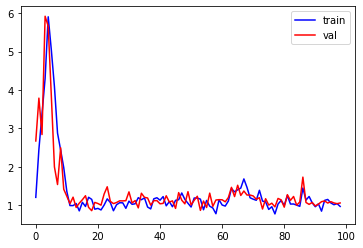

In [554]:
plt.plot(his_los , label = 'train', color=  'blue')
plt.plot(his_val_los , label ='val' , color= 'red')
plt.legend(loc='upper right')
# plt.yscale('log')
plt.show()

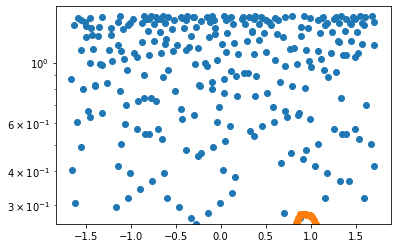

In [557]:
plt.scatter(x_total_val.cpu(), y_total_val.cpu())
plt.scatter(x_total_val.cpu(), y_pred.cpu())
# y_pred_train = net(x_train_b)
# plt.scatter(x_train_b.cpu(), y_train_b.cpu(), color = 'blue')
# plt.scatter(x_train_b.cpu(),y_pred_train.cpu().detach()  , color = 'r')
plt.yscale('log')

plt.show()


In [540]:
x_total_val.size()

torch.Size([10000, 1])

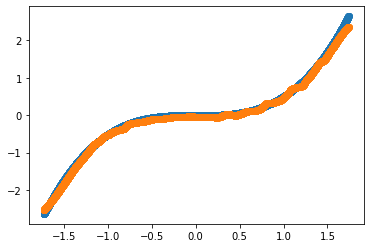

In [523]:
plt.scatter(x_total_val.cpu(), y_total_val.cpu())
plt.scatter(x_total_val.cpu(), y_pred.cpu())
# y_pred_train = net(x_train_b)
# plt.scatter(x_train_b.cpu(), y_train_b.cpu(), color = 'blue')
# plt.scatter(x_train_b.cpu(),y_pred_train.cpu().detach()  , color = 'r')


plt.show()


In [208]:
pca = PCA(n_components=3)
pca_result = pca.fit_transform(np_nn_x)
pca_1 = pca_result[:,0]
pca_2 = pca_result[:,1] 
pca_3 = pca_result[:,2]
pca_df = pd.DataFrame({'one': pca_1,
                      'two': pca_2,
                      'three': pca_3})
print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

Explained variation per principal component: [0.45811515 0.4060207  0.1117506 ]


In [212]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(np_nn_x)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 91531 samples in 0.010s...
[t-SNE] Computed neighbors for 91531 samples in 113.935s...
[t-SNE] Computed conditional probabilities for sample 1000 / 91531
[t-SNE] Computed conditional probabilities for sample 2000 / 91531
[t-SNE] Computed conditional probabilities for sample 3000 / 91531
[t-SNE] Computed conditional probabilities for sample 4000 / 91531
[t-SNE] Computed conditional probabilities for sample 5000 / 91531
[t-SNE] Computed conditional probabilities for sample 6000 / 91531
[t-SNE] Computed conditional probabilities for sample 7000 / 91531
[t-SNE] Computed conditional probabilities for sample 8000 / 91531
[t-SNE] Computed conditional probabilities for sample 9000 / 91531
[t-SNE] Computed conditional probabilities for sample 10000 / 91531
[t-SNE] Computed conditional probabilities for sample 11000 / 91531
[t-SNE] Computed conditional probabilities for sample 12000 / 91531
[t-SNE] Computed conditional probabilities for 

<AxesSubplot:xlabel='t1', ylabel='t2'>

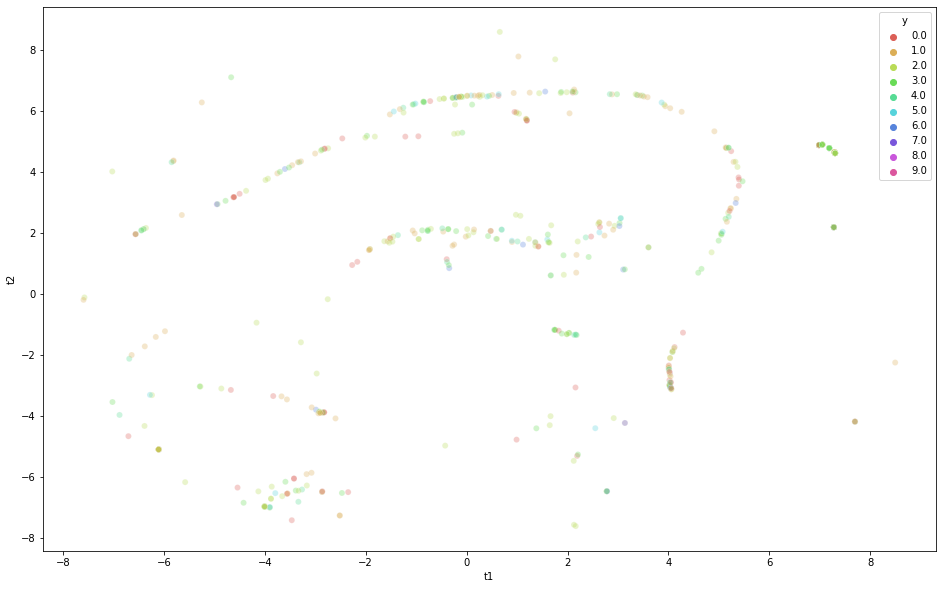

In [224]:
import seaborn as sns
pca_df['t1']=tsne_results[:,0]
pca_df['t2']=tsne_results[:,1]
pca_df['y'] =df_y['label']
plt.figure(figsize=(16,10))
sns.scatterplot(
    x="t1", y="t2",
    hue="y",
    palette=sns.color_palette("hls", 10),
    data=pca_df,
    legend="full",
    alpha=0.3
)

In [216]:
!pip --version

pip 20.3.3 from /home/ican/.local/lib/python3.6/site-packages/pip (python 3.6)


In [159]:
tsne_results

NameError: name 'tsne_results' is not defined